![benchmark](http://media.pennlive.com/davidjones/photo/10094191-large.jpg "starting somewhere...")

### Benchmark Regression Modeling

In [1]:
cd ..

/Users/johnphillips/Desktop/DSI-Class-Stuff/BaseBall


In [2]:
%matplotlib inline

In [3]:
# Imports for Models are in __init__.py file
%run __init__.py

In [4]:
# Start with reading the data from the pickle
teams = pd.read_pickle('data/teams.p')

In [5]:
# Separate the Numeric Columns:

teams_num = teams.select_dtypes(exclude=['object', 'category'])
teams_num.columns

Index([u'yearID', u'G', u'Ghome', u'W', u'L', u'LgWin', u'WSWin', u'R', u'AB',
       u'H', u'2B', u'3B', u'HR', u'BB', u'SO', u'SB', u'CS', u'HBP', u'SF',
       u'RA', u'ER', u'ERA', u'CG', u'SHO', u'SV', u'IPouts', u'HA', u'HRA',
       u'BBA', u'SOA', u'E', u'DP', u'FP', u'attendance', u'BPF', u'PPF',
       u'BA', u'OBP', u'SLG', u'OPS', u'WinP'],
      dtype='object')

### Separate X and y 

In [6]:
# Had to also drop Wins, Losses, and WinP since those are direct indicators.
# And they are not part of a players individual stats.
X = teams_num.drop(['WSWin', 'LgWin', 'W', 'L', 'WinP'], axis=1) 

# Make a y based upon Winning Percentage
y = teams_num['WinP']


In [7]:
X.columns

Index([u'yearID', u'G', u'Ghome', u'R', u'AB', u'H', u'2B', u'3B', u'HR',
       u'BB', u'SO', u'SB', u'CS', u'HBP', u'SF', u'RA', u'ER', u'ERA', u'CG',
       u'SHO', u'SV', u'IPouts', u'HA', u'HRA', u'BBA', u'SOA', u'E', u'DP',
       u'FP', u'attendance', u'BPF', u'PPF', u'BA', u'OBP', u'SLG', u'OPS'],
      dtype='object')

In [8]:
# Train-test split our data...

# Standard split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

### Linear Regression:

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train) 
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.92
Test set score: 0.91


In [10]:
pred_linreg = lr.predict(X_test)

0.25355774251977514


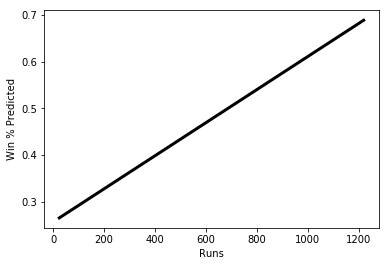

In [11]:
# How predictable are Runs for Winning Percentage?
X_runs = teams_num['R'].values.reshape(-1,1)

# Create the prediction space
prediction_space = np.linspace(min(X_runs), max(X_runs)).reshape(-1,1)

# Fit the model to the data
lr.fit(X_runs, y)

# Compute predictions over the prediction space: y_pred
y_pred = lr.predict(prediction_space)

# Print R^2 
print(lr.score(X_runs, y))

# Plot regression line
plt.plot(prediction_space, y_pred, color='black', linewidth=3)
plt.xlabel('Runs')
plt.ylabel('Win % Predicted')
plt.show()

In [12]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(lr, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.80897607 0.92215944 0.91049345 0.88604384 0.92047577]
Average 5-Fold CV Score: 0.88962971338


In [13]:
# Perform 3-fold CV
cvscores_3 = cross_val_score(lr, X, y, cv=3)
print(np.mean(cvscores_3))

# Perform 10-fold CV
cvscores_10 = cross_val_score(lr, X, y, cv=10)
print(np.mean(cvscores_10))

0.7408618369861552
0.903215014792291


### Lasso :

In [14]:
lasso = Lasso(alpha=0.4, normalize=False)
lasso.fit(X_train, y_train) 
lasso_predict = lasso.predict(X_test)
lasso.score(X_test, y_test)


0.8766698178708779

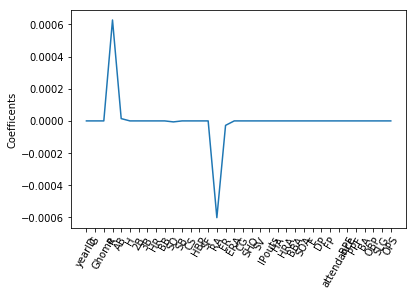

In [15]:
lasso_coef = lasso.fit(X, y).coef_
names = X.columns

_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficents')
plt.show()

# Runs (positively) and Runs Allowed (negatively) seem to be most important for a better Winning Percentage.

### Ridge:

In [16]:
ridge = Ridge(alpha=0.1, normalize=False)
ridge.fit(X_train, y_train)
ridge_predict = ridge.predict(X_test)
ridge.score(X_test, y_test)

0.9135373717413052

In [17]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

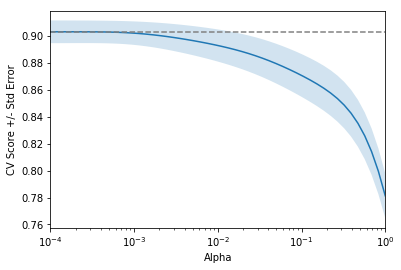

In [18]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

### Elastic Net:

In [19]:

# Create the hyperparameter grid
l1_space = np.linspace(0.001, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(alpha=0.4)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

/Users/johnphillips/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Tuned ElasticNet l1 ratio: {'l1_ratio': 0.001}
Tuned ElasticNet R squared: 0.892180007861
Tuned ElasticNet MSE: 0.000932495619475
